Training CNN with 50 images per category...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.3289 - loss: 2.0322 - val_accuracy: 0.4000 - val_loss: 1.2991
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.2483 - loss: 1.4883 - val_accuracy: 0.2750 - val_loss: 1.3507
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4058 - loss: 1.2032 - val_accuracy: 0.3750 - val_loss: 1.3069
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5730 - loss: 1.0757 - val_accuracy: 0.4250 - val_loss: 1.1944
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6134 - loss: 0.9704 - val_accuracy: 0.5750 - val_loss: 1.1949
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6621 - loss: 0.8608 - val_accuracy: 0.5500 - val_loss: 1.1819
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6379 - loss: 0.8488 - val_accuracy: 0.5500 - val_loss: 1.1690
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7139 - los

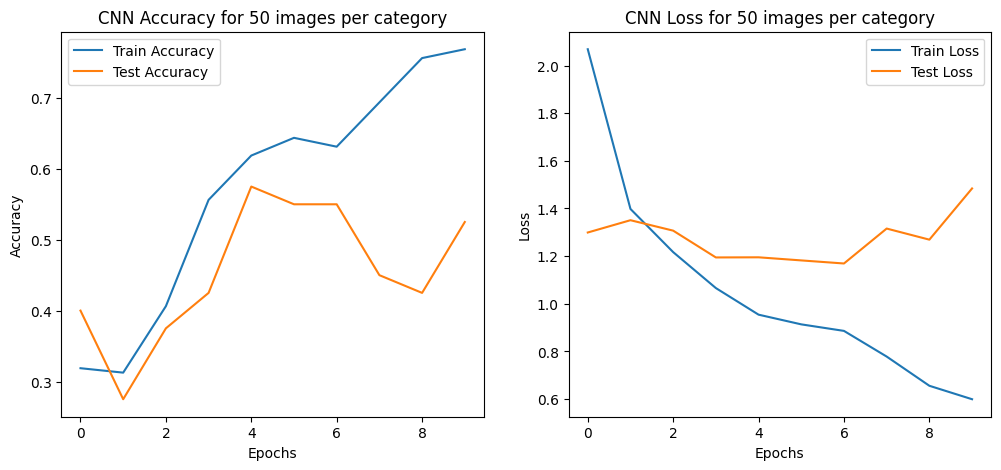

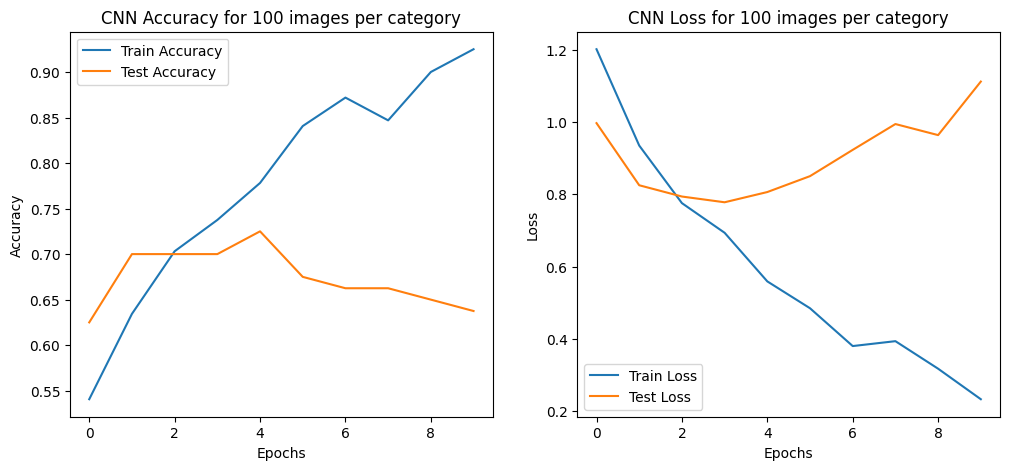

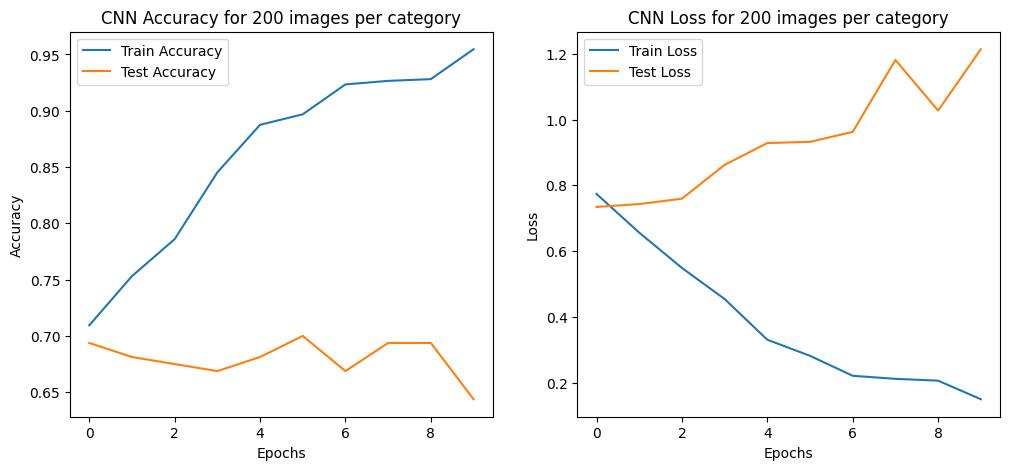

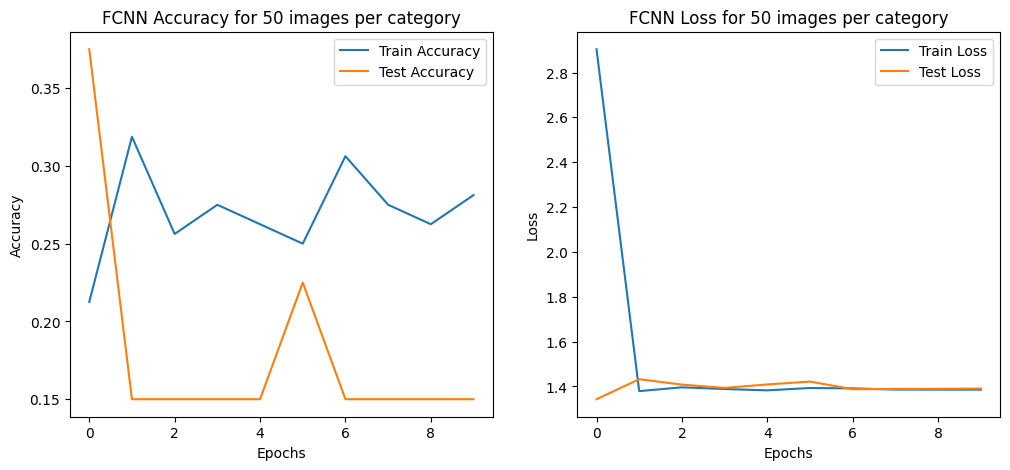

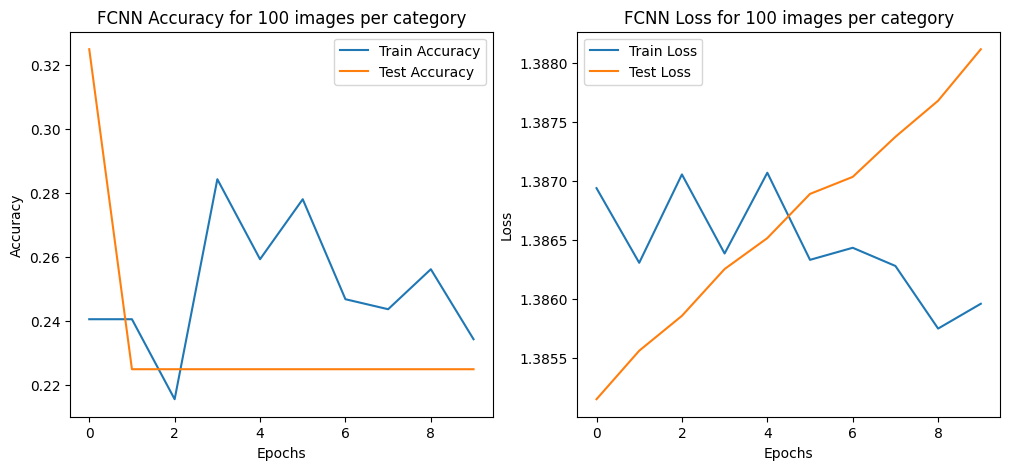

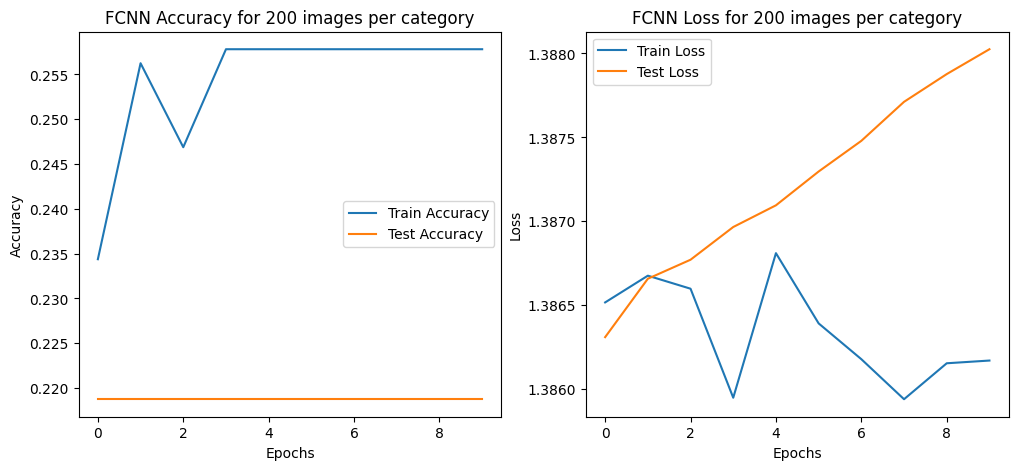

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the directories for the dataset
dataset_dir = 'dataset'
categories = ['brain coral', 'electric ray', 'jellyfish', 'stingray']

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_dir, category)
        for filename in os.listdir(category_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(category_path, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Fuzzification function
def fuzzify_image(image):
    # Normalize image to range 0-1
    image = image / 255.0
    
    # Create fuzzy membership functions
    fuzzified_image = np.zeros((128, 128, 3, 3))  # 3 fuzzy sets for each channel
    for i in range(3):  # for each color channel
        low = np.maximum(1 - image[..., i] * 2, 0)
        medium = np.maximum(1 - np.abs(image[..., i] * 2 - 1), 0)
        high = np.maximum((image[..., i] - 0.5) * 2, 0)
        
        fuzzified_image[..., i, 0] = low
        fuzzified_image[..., i, 1] = medium
        fuzzified_image[..., i, 2] = high
        
    return fuzzified_image

# Load the data
images, labels = load_data()

# Normalize images
images = images / 255.0

# Fuzzify images
fuzzified_images = np.array([fuzzify_image(img) for img in images])

# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the FCNN model
def create_fcnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    convs = []
    for i in range(3):
        conv = Conv2D(32, (3, 3), activation='relu')(inputs[..., i])
        pool = MaxPooling2D((2, 2))(conv)
        conv = Conv2D(64, (3, 3), activation='relu')(pool)
        pool = MaxPooling2D((2, 2))(conv)
        flatten = Flatten()(pool)
        convs.append(flatten)
    
    merged = concatenate(convs)
    dense1 = Dense(128, activation='relu')(merged)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(4, activation='softmax')(dropout)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate the models with different data sizes
def train_and_evaluate(model, data_size, images, labels):
    sampled_images = []
    sampled_labels = []
    
    for label in range(4):
        indices = np.where(labels == label)[0]
        sampled_indices = np.random.choice(indices, data_size, replace=False)
        sampled_images.extend(images[sampled_indices])
        sampled_labels.extend(labels[sampled_indices])
    
    sampled_images = np.array(sampled_images)
    sampled_labels = np.array(sampled_labels)
    
    X_train, X_test, y_train, y_test = train_test_split(sampled_images, sampled_labels, test_size=0.2, random_state=42)
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    return history

# Plotting accuracy and loss for each data size
def plot_histories(histories, data_sizes, title):
    for size in data_sizes:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(histories[size].history['accuracy'], label='Train Accuracy')
        plt.plot(histories[size].history['val_accuracy'], label='Test Accuracy')
        plt.title(f'{title} Accuracy for {size} images per category')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(histories[size].history['loss'], label='Train Loss')
        plt.plot(histories[size].history['val_loss'], label='Test Loss')
        plt.title(f'{title} Loss for {size} images per category')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()

# Create the CNN and FCNN models
cnn_model = create_cnn_model((128, 128, 3))
fcnn_model = create_fcnn_model((128, 128, 3, 3))

# Train and evaluate the models
data_sizes = [50, 100, 200]
cnn_histories = {}
fcnn_histories = {}

for size in data_sizes:
    print(f"Training CNN with {size} images per category...")
    cnn_histories[size] = train_and_evaluate(cnn_model, size, images, labels)
    
    print(f"Training FCNN with {size} images per category...")
    fcnn_histories[size] = train_and_evaluate(fcnn_model, size, fuzzified_images, labels)

# Plot the results
plot_histories(cnn_histories, data_sizes, 'CNN')
plot_histories(fcnn_histories, data_sizes, 'FCNN')
